# Clustering Bike Share Ride Vectors 

In this notebook, we will analyze a pre-processed dataset of ride characteristics extracted from a directory of GPX routes using unsupervised learning techniques in the form of Gaussian Mixture Models.

In [50]:
# Import libraries: NumPy, pandas, matplotlib, metrics
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn


# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Change working directory.
os.chdir(os.getcwd())

## Data

Let's read the data in from its serialized format.  Subset the data with our features of interest.  Note that we are clustering on "location-agnostic" features, as we are solely concerned with the nature of the ride vectors themselves.

In [51]:
# Read dataset.
data = pd.read_pickle("data/data.pkl")

# Subset select metrics.
select_metrics = ['dwell_ratio', 'todest_ratio', 'inride_mph', 'turns/500m']

# Describe data.
print(data[select_metrics].describe())

       dwell_ratio  todest_ratio   inride_mph   turns/500m
count  1028.000000   1028.000000  1028.000000  1028.000000
mean      0.170437      0.883507    16.992453     1.648439
std       0.157820      0.166307     3.822535     0.933851
min       0.000000      0.333333     6.662694     0.245216
25%       0.066667      0.846154    14.300982     1.001893
50%       0.133333      0.953463    16.818530     1.503005
75%       0.230769      1.000000    19.470314     2.105131
max       0.875940      1.000000    28.277262     7.457226


((array([-3.20554261, -2.94093949, -2.79331915, ...,  2.79331915,
          2.94093949,  3.20554261]),
  array([0.21930862, 0.22146264, 0.22581839, ..., 1.98832797, 1.99900976,
         2.13502124])),
 (0.3214844736804363, 0.9199835412573402, 0.9949143411766833))

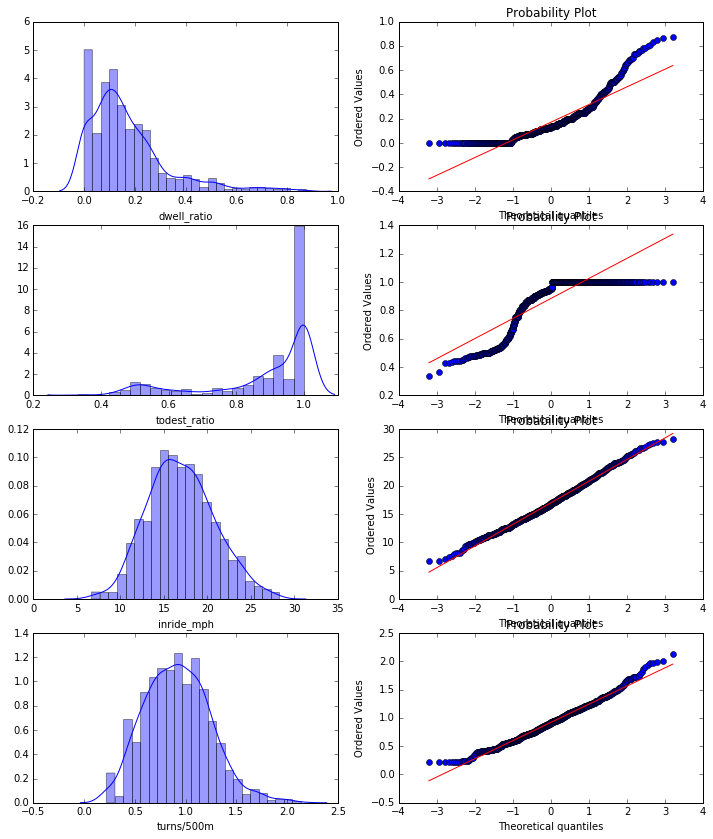

In [52]:
fig,axes = plt.subplots(ncols=2,nrows=4)
fig.set_size_inches(12, 14)

sn.distplot((data['dwell_ratio']),ax=axes[0][0])
stats.probplot(data['dwell_ratio'], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(data['todest_ratio'],ax=axes[1][0])
stats.probplot(data['todest_ratio'], dist='norm', fit=True, plot=axes[1][1])
sn.distplot(data['inride_mph'],ax=axes[2][0])
stats.probplot(data['inride_mph'], dist='norm', fit=True, plot=axes[2][1])
sn.distplot(np.log1p(data['turns/500m']),ax=axes[3][0])
stats.probplot(np.log1p(data['turns/500m']), dist='norm', fit=True, plot=axes[3][1])

## Correlation Analysis

awetaweta

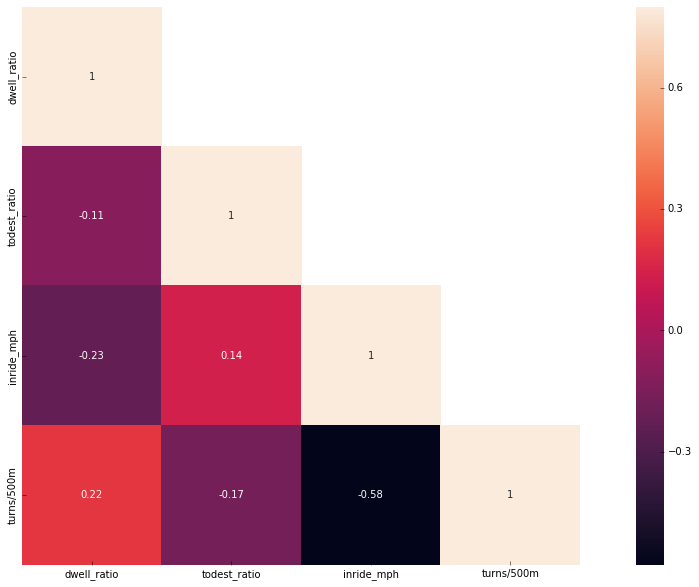

In [53]:
corrMatt = data[select_metrics].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## PCA

PCA components are:
[[ 0.72681856 -0.40482435 -0.41086569  0.37288257]
 [-0.53470254 -0.84028239 -0.05142935  0.07330567]
 [ 0.43106443 -0.35950999  0.63408715 -0.53185478]
 [-0.00337954  0.02820147  0.65305275  0.7567796 ]]

Ranked explained variance of PCA components:
[0.42480993 0.27680578 0.223386   0.0749983 ]

Total explained variance of PCA components:
1.0


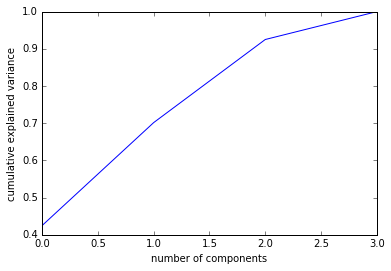

In [58]:
# Init PCA object.
pca_components = 4
pca = PCA(n_components=pca_components)

# Standarize attributes.
standardized_data = (data[select_metrics])/(data[select_metrics].max())

# Fit it to the data.
pca.fit(standardized_data)
    
# Project into PCA coordinates.
fit_data = pd.DataFrame(pca.transform(standardized_data))
fit_data = fit_data.rename(index=str, columns={0: "PCA_1", 1: "PCA_2", 2: "PCA_3"})

# Print the components and the amount of variance in the data contained in each dimension
print "PCA components are:\n", pca.components_
print "\nRanked explained variance of PCA components:\n", pca.explained_variance_ratio_
print "\nTotal explained variance of PCA components:\n", sum(pca.explained_variance_ratio_)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Cluster

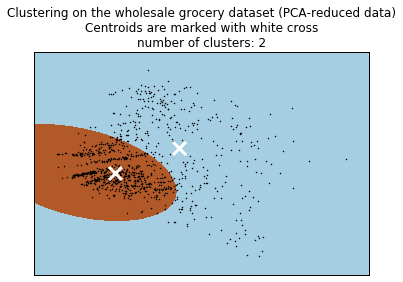

Clustering has a Silhouette Score of 0.442935783002


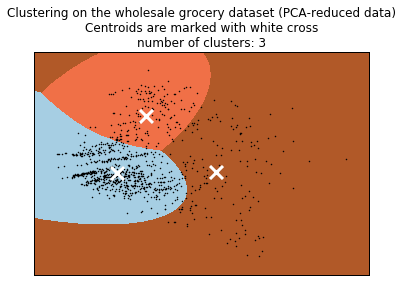

Clustering has a Silhouette Score of 0.457803368959


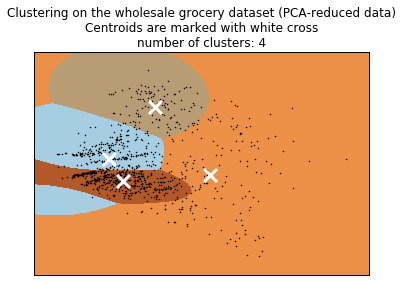

Clustering has a Silhouette Score of 0.296332378288


In [66]:
# Project to two dimension for visualization.
viz_components = 2
pca2 = PCA(n_components=viz_components)

# Fit it to the data.
pca2.fit(standardized_data)
    
# Project into PCA coordinates.
reduced_data = pca2.transform(standardized_data)


# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min()- .1, reduced_data[:, 0].max() + .1
y_min, y_max = reduced_data[:, 1].min() - .1, reduced_data[:, 1].max() + .1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Range of clusters
cluster_range = [2,3,4]

# Plotting Routine
for cluster_num in cluster_range:
    GMM_clf = GaussianMixture(n_components=cluster_num,covariance_type="full").fit(reduced_data)
    GMM_pred = GMM_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    GMM_centroids = GMM_clf.means_
    reshaped_pred = GMM_pred.reshape(xx.shape)
   
    #KMeans_clf = KMeans(n_clusters=cluster_num).fit(reduced_data)
    #KMeans_pred = KMeans_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #KMeans_centroids = KMeans_clf.cluster_centers_
    #reshaped_pred = KMeans_pred.reshape(xx.shape)

    plt.figure(cluster_num)
    plt.clf()
    plt.imshow(reshaped_pred, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(GMM_centroids[:, 0], GMM_centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n'
              'number of clusters: {}'.format(cluster_num))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

    labels = GMM_clf.predict(reduced_data)
    ss = silhouette_score(reduced_data, labels, metric='euclidean')
    print "Clustering has a Silhouette Score of {}".format(ss)


In [72]:
cluster_num = 4
final_gmm = GaussianMixture(n_components=cluster_num,covariance_type="full").fit(fit_data)
average_customer = pca.inverse_transform(final_gmm.means_)

# COUNTS!
labels = pd.DataFrame(final_gmm.predict(fit_data))
scores = pd.DataFrame(final_gmm.predict_proba(fit_data))

## ['dwell_ratio', 'todest_ratio', 'inride_mph']
print "\nAverage ride characteristics of",cluster_num,"ride types:","\n\n", average_customer

ss = silhouette_score(fit_data, labels, metric='euclidean')
print "\nClustering has a Silhouette Score of {}".format(ss)


Average ride characteristics of 4 ride types: 

[[0.19016333 1.         0.62139711 0.20163425]
 [0.0863754  0.90378071 0.60755117 0.20922453]
 [0.48941109 0.72174907 0.49859707 0.33455262]
 [0.13258237 0.61797146 0.61413866 0.20342844]]

Clustering has a Silhouette Score of 0.126671896018


## Output

In [ ]:
data.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)

output = pd.concat([data.route_id, data[select_metrics], labels, scores], axis=1)
output.to_csv('cluster_final.csv')